In [1]:
# !pip install rasterio

In [2]:
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    # Get the current device
    device = torch.cuda.current_device()
    
    # Get the total memory and the allocated memory
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)
    
    # Calculate free memory
    free_memory = total_memory - allocated_memory - cached_memory
    
    print(f"Total memory: {total_memory / 1e9:.2f} GB")
    print(f"Allocated memory: {allocated_memory / 1e9:.2f} GB")
    print(f"Cached memory: {cached_memory / 1e9:.2f} GB")
    print(f"Free memory: {free_memory / 1e9:.2f} GB")
else:
    print("CUDA is not available.")

Total memory: 17.07 GB
Allocated memory: 0.00 GB
Cached memory: 0.00 GB
Free memory: 17.07 GB


In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import cv2
import os
import numpy as np
import rasterio
class Segmentation4bDataset(Dataset):
    def __init__(self, input_dirs, mask_dirs):
        self.input_dirs = input_dirs
        self.mask_dirs = mask_dirs
        image_list = []
        mask_list = []
        for input_dir in input_dirs:
            for file in os.listdir(input_dir):
                if not file.endswith(('.tif', '.tiff')):
                    continue
                image_list.append(os.path.join(input_dir, file))
            
        for mask_dir in mask_dirs:
            for file in os.listdir(mask_dir):
                mask_list.append(os.path.join(mask_dir, file))
            
        self.image_list = sorted(image_list)
        self.mask_list = sorted(mask_list)
        
        assert len(self.image_list) == len(self.mask_list), "The number of images and masks must be the same."

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        dataset = rasterio.open(self.image_list[idx])
        image = np.stack((dataset.read(1), dataset.read(2), dataset.read(3), dataset.read(4)), axis=-1)
        image = np.moveaxis(image, -1, 0)
        
        mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask)

        return image, mask

In [4]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetSegmentation(nn.Module):
    def __init__(self, input_channels=3, num_classes=3):
        super(ResNetSegmentation, self).__init__()
        
        # Load the pre-trained ResNet-34 model
        self.resnet = models.resnet34(weights='IMAGENET1K_V1')
        
        # Modify the first convolutional layer to accept the desired number of input channels
        self.resnet.conv1 = nn.Conv2d(input_channels, 
                                      self.resnet.conv1.out_channels, 
                                      kernel_size=self.resnet.conv1.kernel_size, 
                                      stride=self.resnet.conv1.stride, 
                                      padding=self.resnet.conv1.padding, 
                                      bias=False)
        
        # Extract layers from ResNet
        self.encoder1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu)
        self.encoder2 = nn.Sequential(self.resnet.maxpool, self.resnet.layer1)
        self.encoder3 = self.resnet.layer2
        self.encoder4 = self.resnet.layer3
        self.encoder5 = self.resnet.layer4
        
        # Decoder layers
        self.decoder4 = self._decoder_block(512, 256)
        self.decoder3 = self._decoder_block(256, 128)
        self.decoder2 = self._decoder_block(128, 64)
        self.decoder1 = self._decoder_block(64, 64)
        
        # Final convolution layer to get the desired number of classes
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
        
    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        
        # Decoder with skip connections and spatial alignment
        d4 = self.decoder4(e5)
        d4 = nn.functional.interpolate(d4, size=e4.shape[2:], mode='bilinear', align_corners=False)
        d4 = d4 + e4
        
        d3 = self.decoder3(d4)
        d3 = nn.functional.interpolate(d3, size=e3.shape[2:], mode='bilinear', align_corners=False)
        d3 = d3 + e3
        
        d2 = self.decoder2(d3)
        d2 = nn.functional.interpolate(d2, size=e2.shape[2:], mode='bilinear', align_corners=False)
        d2 = d2 + e2
        
        d1 = self.decoder1(d2)
        d1 = nn.functional.interpolate(d1, size=e1.shape[2:], mode='bilinear', align_corners=False)
        d1 = d1 + e1
        
        # Final convolution to get the segmentation map
        out = self.final_conv(d1)
        out = nn.functional.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out

In [51]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
data_dirs = ['/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/chua_kham_son', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_cuoiha_1',
            '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_cuoiha_2', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/sun_hoabinh_sangolf',
            '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/van_don34', 
             '/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/vinaconex']

mask_dirs = ['/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/chua_kham_son', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/sun_hoabinh_cuoiha_1',
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/sun_hoabinh_cuoiha_2', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/sun_hoabinh_sangolf',
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/van_don34', 
            '/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/vinaconex']

# dataset = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)
dataset = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)
batch_size = 8

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [52]:
input_channels = 4  # For example, for grayscale images
num_classes = 6     # For example, for a 3-class segmentation problem

# Initialize the model
model = ResNetSegmentation(input_channels=input_channels, num_classes=num_classes)

In [54]:
import os
print("running")
# Set the environment variable

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

num_epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

N = len(train_loader.dataset)
torch.cuda.empty_cache()
all_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
#     print("train")
    for inputs, masks in train_loader:  # Assuming `dataloader` is your data loader
        inputs, masks = inputs.to(device), masks.to(device)
        masks = masks.squeeze(1).long()

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / N
    all_loss.append(epoch_loss)
    
    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')
print("complete training model")

running
Epoch 0/299, Loss: 1.3619
Epoch 1/299, Loss: 0.8315
Epoch 2/299, Loss: 0.6510
Epoch 3/299, Loss: 0.5661
Epoch 4/299, Loss: 0.5221
Epoch 5/299, Loss: 0.5079
Epoch 6/299, Loss: 0.4531
Epoch 7/299, Loss: 0.4383
Epoch 8/299, Loss: 0.4032
Epoch 9/299, Loss: 0.3949
Epoch 10/299, Loss: 0.3664
Epoch 11/299, Loss: 0.3603
Epoch 12/299, Loss: 0.3411
Epoch 13/299, Loss: 0.3221
Epoch 14/299, Loss: 0.3136
Epoch 15/299, Loss: 0.3105
Epoch 16/299, Loss: 0.3112
Epoch 17/299, Loss: 0.2938
Epoch 18/299, Loss: 0.2814
Epoch 19/299, Loss: 0.2738
Epoch 20/299, Loss: 0.2784
Epoch 21/299, Loss: 0.2622
Epoch 22/299, Loss: 0.2516
Epoch 23/299, Loss: 0.2671
Epoch 24/299, Loss: 0.2389
Epoch 25/299, Loss: 0.2433
Epoch 26/299, Loss: 0.2226
Epoch 27/299, Loss: 0.2196
Epoch 28/299, Loss: 0.2105
Epoch 29/299, Loss: 0.2190
Epoch 30/299, Loss: 0.1999
Epoch 31/299, Loss: 0.1874
Epoch 32/299, Loss: 0.1848
Epoch 33/299, Loss: 0.1800
Epoch 34/299, Loss: 0.1918
Epoch 35/299, Loss: 0.1885
Epoch 36/299, Loss: 0.1953
Epo

In [55]:
# #save model
model_path = '/kaggle/working/resnet34_trained_4b_6class_300epochs.pth'

# Save the state dictionary of the model
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to /kaggle/working/resnet34_trained_4b_6class_300epochs.pth


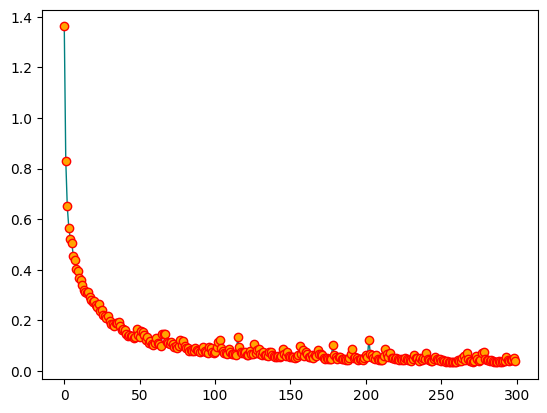

In [56]:
import matplotlib.pyplot as plt
x = [i for i in range(len(all_loss))]
y = all_loss
# plt.plot(x, y, color='orange')
plt.plot(x, y, color = 'teal', marker='o', markeredgecolor='red', markerfacecolor ='orange', linewidth=1, markersize=6)

In [59]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

data_dirs = ['/kaggle/input/crop-scene-400x400/crop_scene_4b/crop_scene_4b/kho_xang']
mask_dirs = ['/kaggle/input/crop-mask-400x400/crop_mask_400_400/6_classes_mask/kho_xang']

test_set = Segmentation4bDataset(input_dirs=data_dirs, mask_dirs=mask_dirs)

batch_size = 8

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [60]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, masks in data_loader:
            inputs, masks = inputs.to(device), masks.to(device)
            masks = masks.squeeze(1).long()

            outputs = model(inputs)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(data_loader.dataset)
    return epoch_loss

test_loss = evaluate_model(model, test_loader, criterion, device)
    
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.9235


In [61]:
#merge patches
import numpy as np
import cv2
import matplotlib.pyplot as plt

def merge(patches, mask_path, patch_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img = np.zeros_like(mask)

    height = patch_size[0]
    width = patch_size[1]

    img_height = mask.shape[0]
    img_width = mask.shape[1]
    ct = 0
    for i in range(0, img_height, height):
        for j in range(0, img_width, width):
            img[i:min(i+height, img_height), j:min(j+width, img_width)] = patches[ct, : min(i+height, img_height)-i, : min(j+width, img_width)-j]
            # unique_vals(img[i:min(i+height, img_height), j:min(j+width, img_width)])
            ct += 1

    return img

In [62]:
from PIL import Image
import cv2
import os
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(model, data_loader, device):
    all_predictions = []
    with torch.no_grad():
        for images in data_loader:
            images = images[0]  # Extract the images tensor from the tuple
            inputs = images.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
    return all_predictions

# Get predictions
predictions = predict(model, test_loader, device)


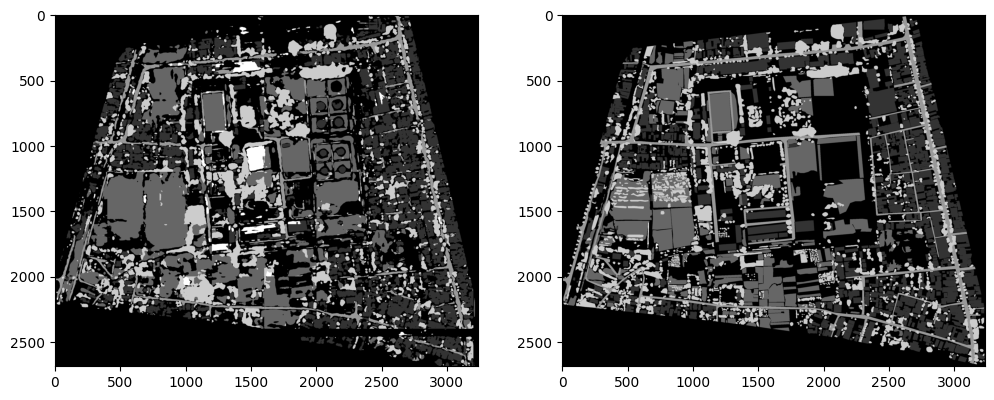

In [64]:
import matplotlib.pyplot as plt
import cv2
# mask_path = '/kaggle/input/masks-set/tree_grass/vinaconex_tree_grass.png'
# mask_path = '/kaggle/input/mask-files/6_classes_mask/chua_kham_son.png'
mask_path = '/kaggle/input/mask-files/6_classes_mask/kho_xang.png'
inferred_img = merge(pred, mask_path, (400,400))

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(inferred_img, cmap='gray')

plt.subplot(1,2,2)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')

plt.show()

In [65]:
#save mask as tiff file
image_path = '/kaggle/input/map-files/scene_3b/kho_xang.tif'
output_path = '/kaggle/working/inferred_kho_xang_resnet34_4b_6class_300eps.tif'
with rasterio.open(image_path) as src:
        # Read the source image data
        profile = src.profile.copy()
        profile.update(count=1)

        with rasterio.open(output_path, 'w', **profile) as tgt:
            # Write the source image data to the target image
            tgt.write(inferred_img, 1)

In [66]:
# bgr_image = cv2.imread('/kaggle/input/map-files/scene_3b/chua_kham_son.tif')
bgr_image = cv2.imread('/kaggle/input/map-files/scene_3b/kho_xang.tif')
rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB) 
color_seg = np.copy((rgb_image * 0.5).astype(np.uint8))

id2label = {
    0: 'background',
    1: 'building',
    2: 'grass',
    3: 'road',
    4: 'tree',
    5: 'water'
}

# label2color = {
#     'background': [0,0,0],
#     'tree': [37,110,10],
#     'grass': [240,19,19]
# }

id2color = {
    0: [0,0,0],
    1: [240,19,19],
    2: [141,253,113],
    3: [193,201,88],
    4: [6,132,27],
    5: [52,85,247]
}


for label, color in id2color.items():
    color_seg[inferred_img == label, :] = color

img = rgb_image * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)


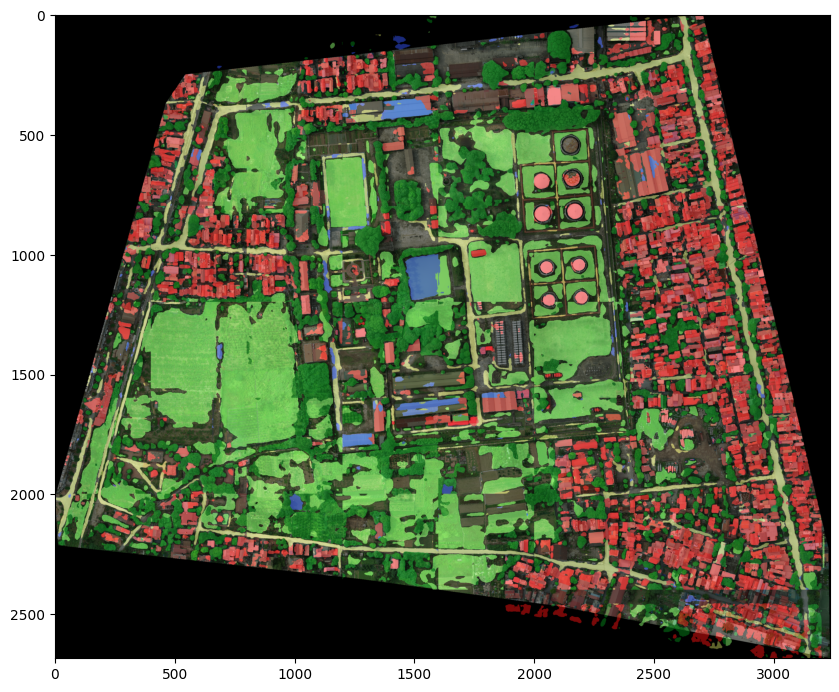

In [67]:
# plt.figure(figsize=(15, 15))
plt.figure(figsize=(10, 10))
# plt.subplot(1,2,1)
# plt.imshow(img)

# plt.subplot(1,2,2)
# plt.imshow(rgb_image)
plt.imshow(img)
plt.show()

In [68]:
mask_path = '/kaggle/input/mask-files/6_classes_mask/kho_xang.png'
ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

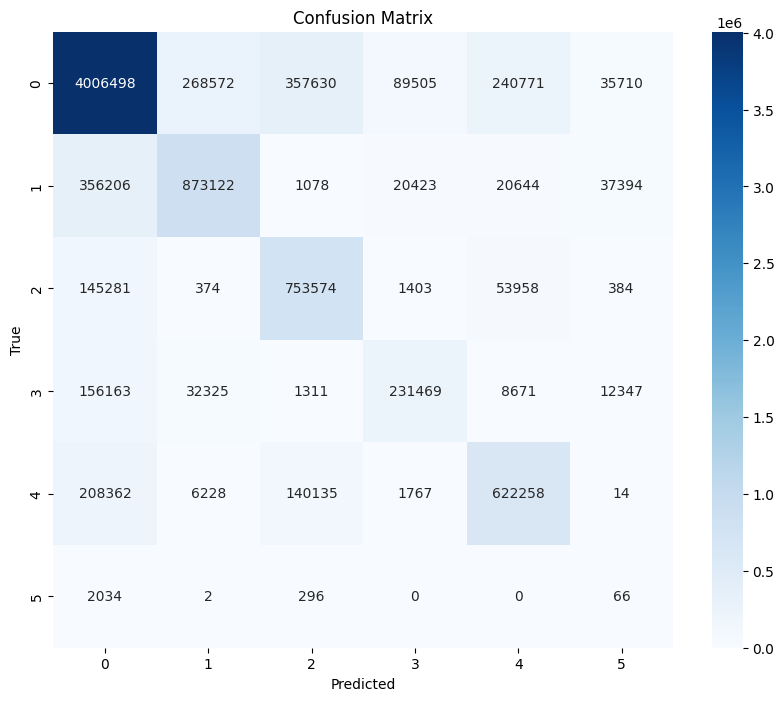

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


label = ground_truth.ravel()
pred = inferred_img.ravel()

# cm = confusion_matrix(label, pred, labels=[0, 1, 2])
cm = confusion_matrix(label, pred, labels=[0, 1, 2, 3, 4, 5])


# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [70]:
import torch
import torchmetrics

# Example labels and predictions for 3 classes (0, 1, 2)
labels = torch.tensor(label)
predictions = torch.tensor(pred)

# Define the task
task = 'multiclass'
num_classes = 6
# Initialize metrics
precision = torchmetrics.Precision(task=task, average='macro', num_classes=num_classes)
recall = torchmetrics.Recall(task=task, average='macro', num_classes=num_classes)
f1_score = torchmetrics.F1Score(task=task, average='macro', num_classes=num_classes)
accuracy = torchmetrics.Accuracy(task=task, num_classes=num_classes)
iou = torchmetrics.JaccardIndex(task=task, num_classes=num_classes)

# Compute metrics
precision_value = precision(predictions, labels)
recall_value = recall(predictions, labels)
f1_value = f1_score(predictions, labels)
accuracy_value = accuracy(predictions, labels)

# Print results
print(f'Precision: {precision_value:.4f}')
print(f'Recall: {recall_value:.4f}')
print(f'F1 Score: {f1_value:.4f}')
print(f'Accuracy: {accuracy_value:.4f}')


Precision: 0.5821
Recall: 0.5741
F1 Score: 0.5719
Accuracy: 0.7468
